<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/DL_final_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!apt-get install -q openslide-tools
!pip install openslide-python

Reading package lists...
Building dependency tree...
Reading state information...
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os 
from PIL import Image
from skimage.color import rgb2gray
import random
import tensorflow as tf
import numpy as np

In [8]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop


In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def deep_scan(slide, mask, x, y, s, m, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = None
  print('slide width (x-axis) {}  || depth (y-axis) {} || channel {}'.format(s.shape[1], s.shape[0], s.shape[2])) # if you use np.shape, remember to swap
  print('mask  width (x-axis) {}  || depth (y-axis) {} ||'.format(m.shape[1], m.shape[0]))
  print('deep scan at coordinate: ({:<5} (x-axis), {:<5} (y-aixs))\n'.format(x, y))
  
  # s and m are already np array, not the open-slide object
  if m[y][x]:
    print('this pixel is marked as tumor', '[positive]')
  else:
    print('this pixel is not marked as tumor', '[negative]')
   
  # scan all levels for a (width * height) image
  for i in range(0, ALL_LEVEL):
    plt.subplot(2, 4, i + 1)
    region = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=i, width=width, height=height)
    if i == lv: path = region
    plt.imshow(region)
  
  return patch
  
def get_patch(slide, mask, x, y, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def find_tumor_pixels(m):
  return [(j, i) for i, row in enumerate(m)
              for j, c in enumerate(row) if c]

# s: the tumor image at some level
# intensity: threshold to filter the image
def find_tissue_pixels(s, intensity=0.8):
  s_gray = rgb2gray(s)
  idx = np.where(s_gray <= intensity)
  return zip(idx[1], idx[0])

def print_slide(slide_name=None, mask_name=None):
  if not slide_name and not mask_name: return
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  if slide_name:
    slide_path = os.path.join(path, slide_name)
    slide = open_slide(slide_path)
    s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
    
  if mask_name:
    mask_path = os.path.join(path, mask_name)
    mask = open_slide(mask_path)
    m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  
  plt.figure(figsize=(4, 4), dpi=100)
  if slide_name:
    plt.imshow(s)
    plt.title(slide_path.split('/')[-1])
  if mask_name:
    plt.imshow(m, cmap='jet', alpha=0.5)
  if slide_name and mask_name:
    loc_tissue = list(find_tissue_pixels(s, 0.8))
    loc_tumor = find_tumor_pixels(m)
    print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_helper(slide_name, mask_name):
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]  
  return slide, mask, s, m
def _get_info(slide_name, mask_name):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tumor = find_tumor_pixels(m)
  print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_locs(slide_name, mask_name):
  """loc_tissue, loc_tumor, loc_normal"""
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tissue = set(loc_tissue)
  loc_tumor = find_tumor_pixels(m)
  loc_tumor = set(loc_tumor)
  loc_normal = loc_tissue - loc_tumor
  return loc_tissue, loc_tumor, loc_normal


def get_patch2(slide, x, y, width=299, height=299, lv=0):
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()


In [0]:
import gc
def _train_on_batch3(batch_size=2000):
  for i in range(0, len(normal), batch_size):
    print('training on batch {} / {}'.format(i//batch_size+1, len(normal)//batch_size))
    batch = slice(i, i + batch_size)
    print('current first 10 locations:\ntumor {}\nnormal{}'.format(str(tumor[batch][:10]), str(normal[batch][:10])))
    images = []
    labels = [] # should be here
    for j, loc in enumerate(tumor[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(1)
      if j % 1000 == 0: print('processing {:<2f}%'.format(100 *(j + 1) / batch_size ))
    for j, loc in enumerate(normal[batch]):
      patch = get_patch2(slide, *loc, 299, 299, 4)
      images.append(patch)
      labels.append(0)
      if j % 1000 == 0: print('processing {:<2f}%'.format(100 *(j + 1) / batch_size ))
    images = np.array(images)    
    labels = np.array(labels)    
    features = conv_base.predict(images)
    train_features = np.reshape(features, (len(features), -1))
    del features
    model.fit(train_features, labels, epochs=1, batch_size=128)
    save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_0504_batchId{}.h5'.format(i//batch_size + 1)
    model.save(save_dir)
    del images
    del labels
    del train_features

**try to slove the overfitting**

Increase the capacity of thde model then traing on tumor_078.tif again and predict on tumor_110.tif

try different level of patchs

many patchs could be similar, let me try just train 1 or 2 epochs

If the result looks good, develope a quantitative metric.

kind of for each predicted cell count the true tumor near it, something like that

tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)


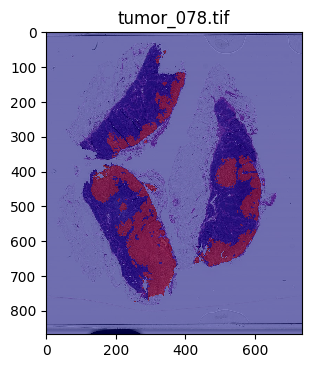

In [17]:
print_slide('tumor_078.tif', 'tumor_078_mask.tif')

tumor_110.tif        || tissue     137357  ||  tumor      64266 (46.787568%)


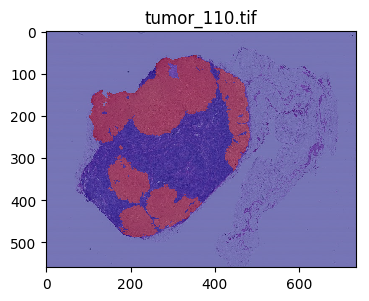

In [0]:
print_slide('tumor_110.tif', 'tumor_110_mask.tif')

In [0]:
slide, mask, s, m = _get_helper('tumor_078.tif', 'tumor_078_mask.tif')

In [19]:
from tensorflow.keras.applications import ResNet50, InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87916544/87910968 [==============================] - 7s 0us/step


In [0]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=8*8*2048))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=2e-3), loss='binary_crossentropy', metrics=['acc'])

In [0]:
loc_tissue, loc_tumor, loc_normal = _get_locs('tumor_078.tif', 'tumor_078_mask.tif')
normal = list(loc_normal)
random.shuffle(normal)
normal = normal[:len(loc_tumor)]
tumor = list(loc_tumor)
tissue = list(loc_tissue)

In [0]:
EPOCHS = 1
for epoch in range(EPOCHS):
  print('EPOCH: {} / {}'.format(epoch + 1, EPOCHS))
  _train_on_batch3(batch_size=3000)

EPOCH: 1 / 1
training on batch 1 / 19
current first 10 locations:
tumor [(176, 465), (273, 617), (492, 635), (254, 622), (328, 748), (526, 620), (263, 638), (581, 527), (360, 157), (466, 646)]
normal[(603, 361), (274, 124), (379, 678), (510, 456), (209, 204), (536, 276), (375, 661), (149, 304), (517, 168), (218, 855)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [==============================] - 5s 786us/sample - loss: 200.5762 - acc: 0.6288
training on batch 2 / 19
current first 10 locations:
tumor [(210, 341), (565, 621), (489, 410), (270, 651), (362, 680), (318, 695), (341, 638), (343, 192), (253, 322), (200, 338)]
normal[(320, 43), (301, 521), (80, 554), (219, 840), (303, 776), (578, 339), (278, 231), (510, 460), (549, 559), (195, 557)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [============

In [0]:
# if the performance is not good I could train another epoch

In [0]:
save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_part3/model_0_0507.h5'
model.save(save_dir)

In [0]:
import gc

def _forward(img):
  return conv_base.predict(img)

def _make_prediction2(model, slide_name, mask_name, batch_size=4000):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  loc_tissue, loc_tumor, loc_normal = _get_locs(slide_name, mask_name)
  tissue = list(loc_tissue)
  prediction = []
  for i in range(0, len(tissue), batch_size):
    print('predicting on batch {} / {}'.format(i//batch_size+1, len(tissue)//batch_size+1))
    batch = slice(i, i + batch_size)
    images = [get_patch2(slide, *loc, 299, 299, 4) for loc in tissue[batch]] # the level is 4
    images = np.array(images)
    images = _forward(images)
    images = np.reshape(images, (len(images), -1))
    pred = model.predict(images)
    del images
    prediction.append(pred)
  return prediction

In [0]:
import time
_start_time = time.time()
prediction_110 = _make_prediction2(model, 'tumor_110.tif', 'tumor_110_mask.tif', 5000)
print('Done {}s'.format(time.time()-_start_time))

predicting on batch 1 / 28
predicting on batch 2 / 28
predicting on batch 3 / 28
predicting on batch 4 / 28
predicting on batch 5 / 28
predicting on batch 6 / 28
predicting on batch 7 / 28
predicting on batch 8 / 28
predicting on batch 9 / 28
predicting on batch 10 / 28
predicting on batch 11 / 28
predicting on batch 12 / 28
predicting on batch 13 / 28
predicting on batch 14 / 28
predicting on batch 15 / 28
predicting on batch 16 / 28
predicting on batch 17 / 28
predicting on batch 18 / 28
predicting on batch 19 / 28
predicting on batch 20 / 28
predicting on batch 21 / 28
predicting on batch 22 / 28
predicting on batch 23 / 28
predicting on batch 24 / 28
predicting on batch 25 / 28
predicting on batch 26 / 28
predicting on batch 27 / 28
predicting on batch 28 / 28
Done 2363.0308454036713s


In [0]:
def gen_mask(s, loc, color=(255, 0, 0)):
  mask = np.zeros(shape=s.shape)
  for i, j in loc:
    mask[j][i] = color
  return mask
  
def gen_mask2(prediction, slide_name, mask_name):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  loc_tissue, loc_tumor, loc_normal = _get_locs(slide_name, mask_name)
  tissue = list(loc_tissue)
  pred = np.copy(prediction)
  _pred = [p for batch in pred for p in batch]
  _pred_loc = []
  for i, loc in enumerate(tissue):
    if _pred[i] > 0.5:
      _pred_loc.append(loc)
  s_mask = gen_mask(s, _pred_loc)
  return s_mask

def _print_test(prediction, slide_name, mask_name, sz=20):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  s_mask = gen_mask2(prediction, slide_name, mask_name)
  plt.figure(figsize=(sz, sz))
  plt.imshow(s)
  plt.imshow(m, cmap='jet', alpha=0.5)
  plt.title('ground truth')

  plt.figure(figsize=(sz, sz))
  plt.imshow(s)
  plt.imshow(s_mask, cmap='jet', alpha=0.5)
  plt.title('predicted')

  plt.figure(figsize=(sz, sz))
  plt.imshow(s, alpha=0.5)
  plt.imshow(s_mask, alpha=0.4)
  plt.imshow(m, alpha=0.4)
  plt.title('comparison')

In [0]:
s_mask = gen_mask2(prediction_110, 'tumor_110.tif', 'tumor_110_mask.tif')

W0507 17:27:25.269267 140002291459968 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


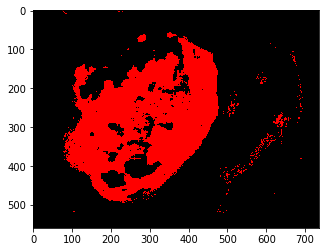

In [0]:
plt.imshow(s_mask)

W0507 17:32:06.427655 140002291459968 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0507 17:32:06.475477 140002291459968 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


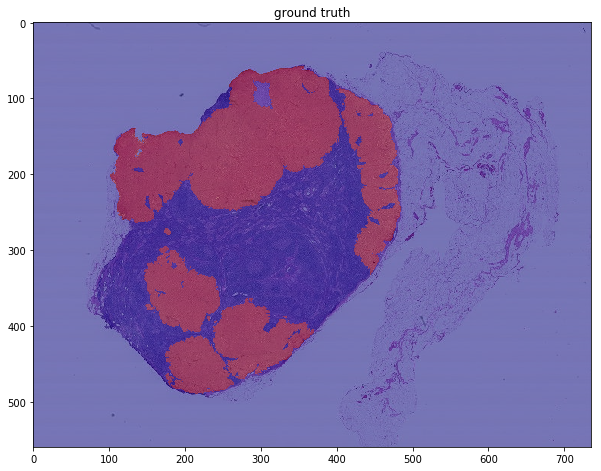

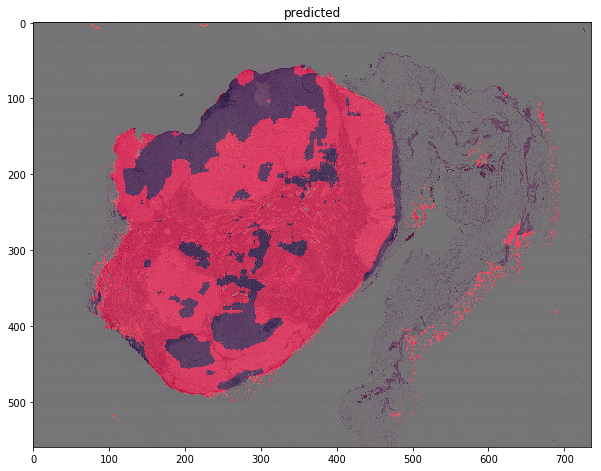

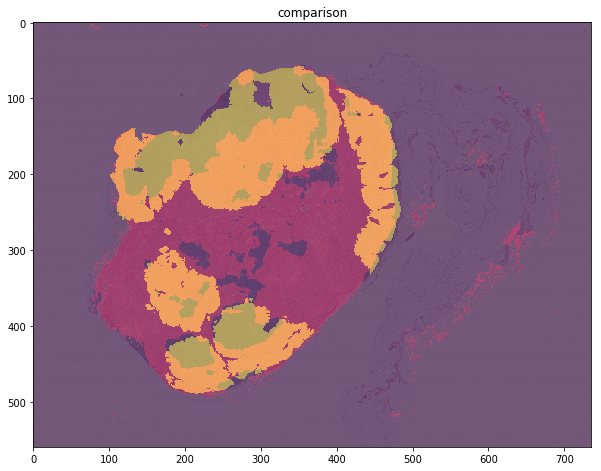

In [0]:
_print_test(prediction_110, 'tumor_110.tif', 'tumor_110_mask.tif', 10)

too many false potive

tarin another 1 or 2 epochs and test again

In [0]:
save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_part3/model_0_0507.h5'

In [0]:
model = tf.keras.models.load_model(save_dir)

In [0]:
EPOCHS = 1
for epoch in range(EPOCHS):
  print('EPOCH: {} / {}'.format(epoch + 1, EPOCHS))
  _train_on_batch3(batch_size=3000)

EPOCH: 1 / 1
training on batch 1 / 19
current first 10 locations:
tumor [(176, 465), (273, 617), (492, 635), (254, 622), (328, 748), (526, 620), (263, 638), (581, 527), (360, 157), (466, 646)]
normal[(544, 288), (485, 202), (226, 185), (161, 867), (162, 276), (315, 858), (201, 575), (478, 357), (238, 660), (519, 255)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [==============================] - 4s 686us/sample - loss: 1.0540 - acc: 0.7548
training on batch 2 / 19
current first 10 locations:
tumor [(210, 341), (565, 621), (489, 410), (270, 651), (362, 680), (318, 695), (341, 638), (343, 192), (253, 322), (200, 338)]
normal[(544, 484), (519, 201), (440, 586), (481, 228), (227, 178), (158, 493), (262, 323), (211, 629), (218, 455), (509, 860)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [============

In [0]:
# another epoch
EPOCHS = 1
for epoch in range(EPOCHS):
  print('EPOCH: {} / {}'.format(epoch + 1, EPOCHS))
  _train_on_batch3(batch_size=3000)

EPOCH: 1 / 1
training on batch 1 / 19
current first 10 locations:
tumor [(176, 465), (273, 617), (492, 635), (254, 622), (328, 748), (526, 620), (263, 638), (581, 527), (360, 157), (466, 646)]
normal[(544, 288), (485, 202), (226, 185), (161, 867), (162, 276), (315, 858), (201, 575), (478, 357), (238, 660), (519, 255)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [==============================] - 3s 513us/sample - loss: 0.4838 - acc: 0.8112
training on batch 2 / 19
current first 10 locations:
tumor [(210, 341), (565, 621), (489, 410), (270, 651), (362, 680), (318, 695), (341, 638), (343, 192), (253, 322), (200, 338)]
normal[(544, 484), (519, 201), (440, 586), (481, 228), (227, 178), (158, 493), (262, 323), (211, 629), (218, 455), (509, 860)]
processing 0.033333%
processing 33.366667%
processing 66.700000%
processing 0.033333%
processing 33.366667%
processing 66.700000%
6000/6000 [============

In [0]:
save_dir = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_part3/model_3_0507.h5'
model.save(save_dir)

In [0]:
# test again, after training for 3 epochs
model = tf.keras.models.load_model('/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_part3/model_3_0507.h5')

In [23]:
import time
_start_time = time.time()
prediction_110 = _make_prediction2(model, 'tumor_110.tif', 'tumor_110_mask.tif', 5000)
print('Done {}s'.format(time.time()-_start_time))

predicting on batch 1 / 28
predicting on batch 2 / 28
predicting on batch 3 / 28
predicting on batch 4 / 28
predicting on batch 5 / 28
predicting on batch 6 / 28
predicting on batch 7 / 28
predicting on batch 8 / 28
predicting on batch 9 / 28
predicting on batch 10 / 28
predicting on batch 11 / 28
predicting on batch 12 / 28
predicting on batch 13 / 28
predicting on batch 14 / 28
predicting on batch 15 / 28
predicting on batch 16 / 28
predicting on batch 17 / 28
predicting on batch 18 / 28
predicting on batch 19 / 28
predicting on batch 20 / 28
predicting on batch 21 / 28
predicting on batch 22 / 28
predicting on batch 23 / 28
predicting on batch 24 / 28
predicting on batch 25 / 28
predicting on batch 26 / 28
predicting on batch 27 / 28
predicting on batch 28 / 28
Done 2424.2663266658783s


W0508 16:11:54.872792 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


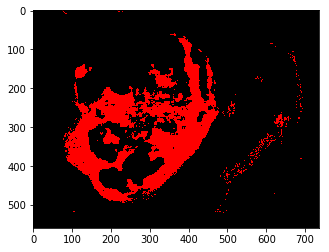

In [27]:
s_mask = gen_mask2(prediction_110, 'tumor_110.tif', 'tumor_110_mask.tif')
plt.imshow(s_mask)

W0508 16:12:12.814383 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0508 16:12:12.857347 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


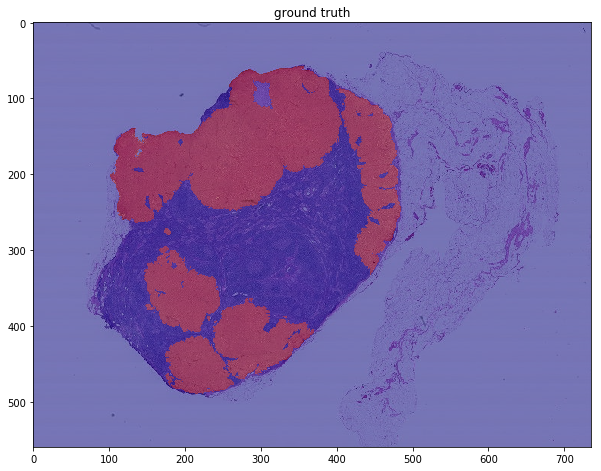

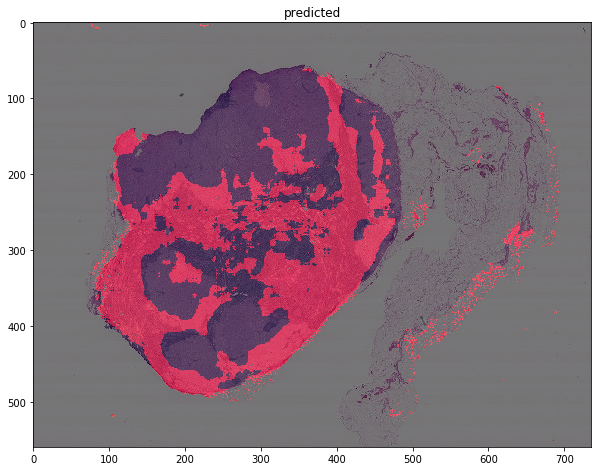

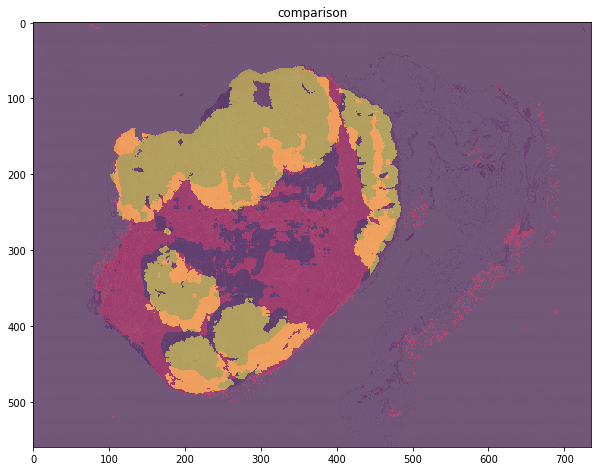

In [28]:
_print_test(prediction_110, 'tumor_110.tif', 'tumor_110_mask.tif', 10)

In [29]:
import time
_start_time = time.time()
prediction_078 = _make_prediction2(model, 'tumor_078.tif', 'tumor_078_mask.tif', 5000)
print('Done {}s'.format(time.time()-_start_time))

predicting on batch 1 / 44
predicting on batch 2 / 44
predicting on batch 3 / 44
predicting on batch 4 / 44
predicting on batch 5 / 44
predicting on batch 6 / 44
predicting on batch 7 / 44
predicting on batch 8 / 44
predicting on batch 9 / 44
predicting on batch 10 / 44
predicting on batch 11 / 44
predicting on batch 12 / 44
predicting on batch 13 / 44
predicting on batch 14 / 44
predicting on batch 15 / 44
predicting on batch 16 / 44
predicting on batch 17 / 44
predicting on batch 18 / 44
predicting on batch 19 / 44
predicting on batch 20 / 44
predicting on batch 21 / 44
predicting on batch 22 / 44
predicting on batch 23 / 44
predicting on batch 24 / 44
predicting on batch 25 / 44
predicting on batch 26 / 44
predicting on batch 27 / 44
predicting on batch 28 / 44
predicting on batch 29 / 44
predicting on batch 30 / 44
predicting on batch 31 / 44
predicting on batch 32 / 44
predicting on batch 33 / 44
predicting on batch 34 / 44
predicting on batch 35 / 44
predicting on batch 36 / 44
p

W0508 17:30:43.305401 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


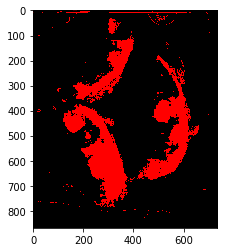

In [30]:
s_mask = gen_mask2(prediction_078, 'tumor_078.tif', 'tumor_078_mask.tif')
plt.imshow(s_mask)

W0508 17:31:28.622554 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0508 17:31:28.680086 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


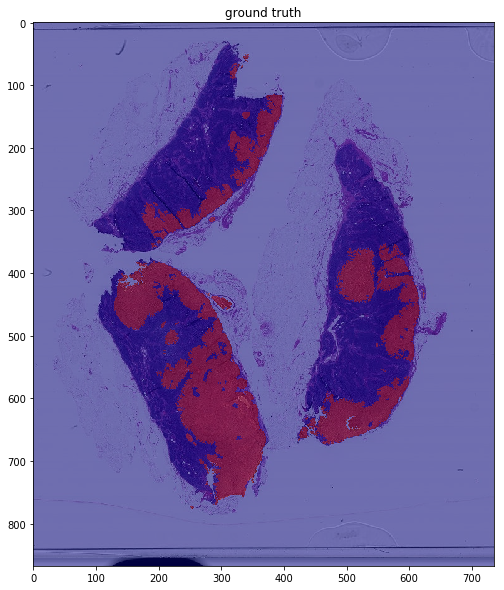

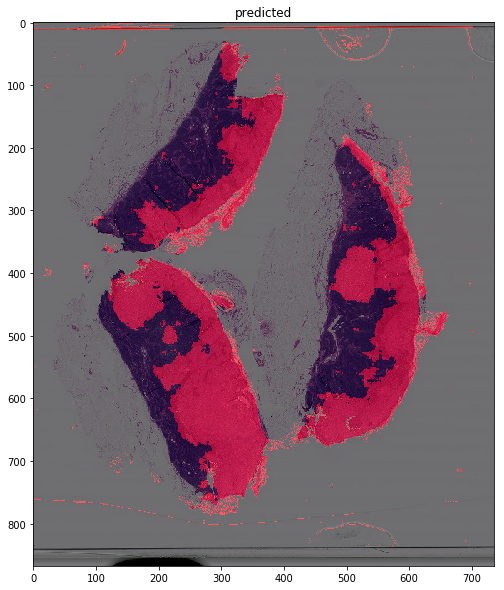

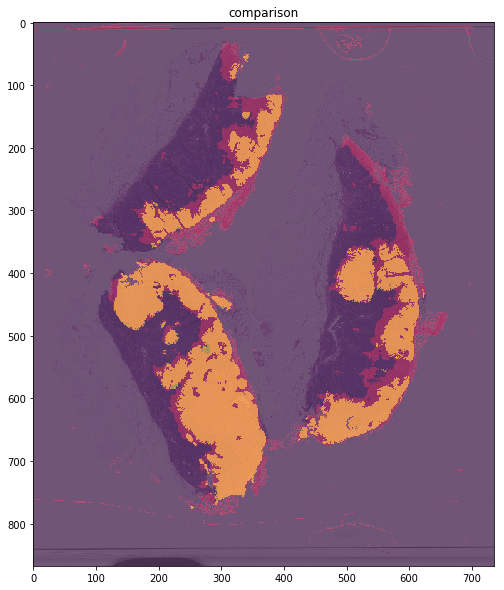

In [31]:
_print_test(prediction_078, 'tumor_078.tif', 'tumor_078_mask.tif', 10)

In [32]:
# test on tumor_091.tif
import time
_start_time = time.time()
prediction_091 = _make_prediction2(model, 'tumor_091.tif', 'tumor_091'/_mask.tif', 5000)
print('Done {}s'.format(time.time()-_start_time))

predicting on batch 1 / 13
predicting on batch 2 / 13
predicting on batch 3 / 13
predicting on batch 4 / 13
predicting on batch 5 / 13
predicting on batch 6 / 13
predicting on batch 7 / 13
predicting on batch 8 / 13
predicting on batch 9 / 13
predicting on batch 10 / 13
predicting on batch 11 / 13
predicting on batch 12 / 13
predicting on batch 13 / 13
Done 894.6224250793457s


W0508 18:11:05.898892 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0508 18:11:06.673671 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0508 18:11:06.706445 139744329017216 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


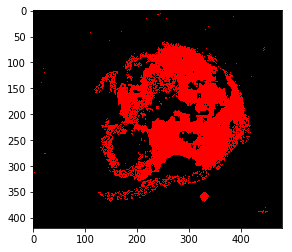

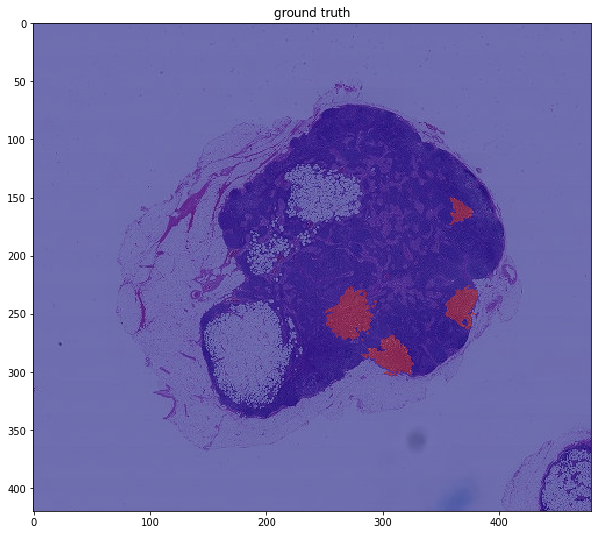

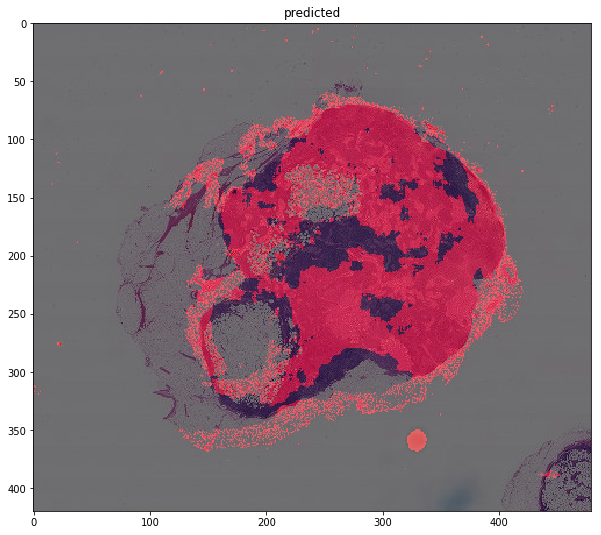

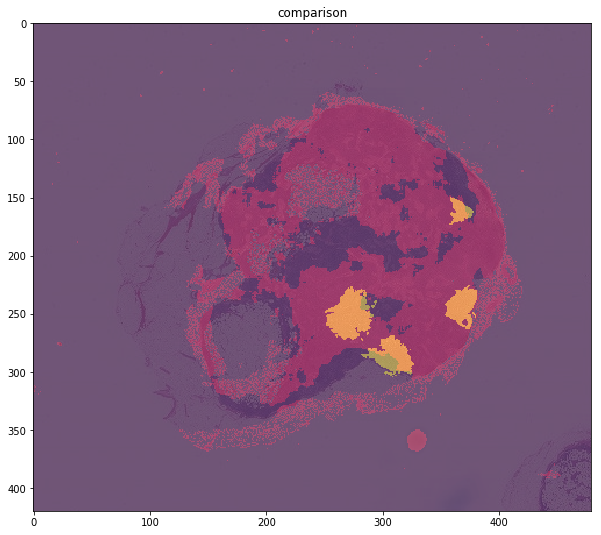

In [34]:
s_mask = gen_mask2(prediction_091, 'tumor_091.tif', 'tumor_091_mask.tif')
plt.imshow(s_mask)

_print_test(prediction_091, 'tumor_091.tif', 'tumor_091_mask.tif', 10)

train another 2 epochs and then train on other slides
